# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
#import sys
#sqlalchemy_utils.__version__
#from distutils.sysconfig import get_python_lib
#print(get_python_lib())
from time import time
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists
import pickle

import nltk
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger', 'stopwords'])
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import string

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kbaka\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kbaka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\kbaka\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kbaka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Inspect data

In [2]:
database_filepath = "data/disaster_response.db"
database_exists(f'sqlite:///{database_filepath}') 
engine = create_engine(f'sqlite:///{database_filepath}')
connection = engine.connect()
df = pd.read_sql_table("messages_categories", con=connection)
df.head()

,id,message,original,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,...,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,direct,news
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,1,0,0,1,0,0,0,...,1,0,1,0,0,0,0,0,1,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,1,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [3]:
df.columns

Index(['id', 'message', 'original', 'related', 'request', 'offer',
       'aid_related', 'medical_help', 'medical_products', 'search_and_rescue',
       'security', 'military', 'child_alone', 'water', 'food', 'shelter',
       'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
       'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
       'other_weather', 'direct_report', 'direct', 'news'],
      dtype='object')

In [4]:
for col in df.iloc[:, 3:]:
    print(df[col].unique())

[1 0 2]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[1 0]
[0 1]


In [5]:
def load_data(database_filepath):
    '''
    Input:
        database_filename(str): Filepath of the database.
    Output:
        X(numpy.ndarray): Array of input features.
        y(numpy.ndarray): Output labels, classes.
    '''

    try:
        database_exists(f'sqlite:///{database_filepath}') 
        engine = create_engine(f'sqlite:///{database_filepath}')
        connection = engine.connect()

        df = pd.read_sql_table("messages_categories", con=connection)
        labels = df.iloc[:,4:].columns

        X = df["message"].values
        y = df.iloc[:,4:].values
         

        connection.close()

        return X, y, labels
    
    except:
        print("Database does not exist! Check your database_filepath!")


### 2. Write a tokenization function to process your text data

In [6]:
def tokenize(text):
    ''' Normalize, lemmantize and tokenize text messages.
    Input:
        text(str): Text messages.
    Output:
        clean_tokens(str): Normalize, lemmantize and tokenize text messages.
    '''
    stop_words = set(stopwords.words('english'))

    # normalize text
    normalized_text = text.lower().strip()

    # tokenize text
    tokens = word_tokenize(normalized_text)
    
    # lemmantize text and remove stop words and non alpha numericals 
    clean_tokens = [] 
    for token in tokens:
        lemmatizer = WordNetLemmatizer()
        clean_token = lemmatizer.lemmatize(token)

        if clean_token not in stop_words and clean_token.isalpha():
            clean_tokens.append(clean_token)
            
    return clean_tokens

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [7]:
#https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/

In [8]:
X, y, labels = load_data("data/disaster_response.db")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
X_train

array(['**Provisional conclusions and recommendations** At the end of his visit the Special Rapporteur said: "Burkina Faso has so far escaped the threat of terrorist attack, the spread of armed conflict across its borders, and the religious intolerance, radicalization and violent extremism among its population.',
       'They are offering psycho-social support and free medical care using the voluntary services of doctors.',
       '* How do beneficiaries (gender/economic status) in varying circumstances (emergency/non-emergency) spend cash?',
       ...,
       'Hello people in the courtyard of Miki at fontamara 27 Menos street extension, water please, do something',
       'Each day, 1,700 women go into labour and hundreds experience complications requiring life-saving medical intervention.',
       'This scenario could destabilize the entire Horn of Africa region, say the three aid agencies.'],
      dtype=object)

In [10]:
y_train

array([[0, 0, 1, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [1, 0, 1, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int64)

In [11]:
labels

Index(['request', 'offer', 'aid_related', 'medical_help', 'medical_products',
       'search_and_rescue', 'security', 'military', 'child_alone', 'water',
       'food', 'shelter', 'clothing', 'money', 'missing_people', 'refugees',
       'death', 'other_aid', 'infrastructure_related', 'transport',
       'buildings', 'electricity', 'tools', 'hospitals', 'shops',
       'aid_centers', 'other_infrastructure', 'weather_related', 'floods',
       'storm', 'fire', 'earthquake', 'cold', 'other_weather', 'direct_report',
       'direct', 'news'],
      dtype='object')

In [12]:
for data in [X_train, X_test, y_train, y_test]:
    print(data.shape, type(data))

(20972,) <class 'numpy.ndarray'>
(5244,) <class 'numpy.ndarray'>
(20972, 37) <class 'numpy.ndarray'>
(5244, 37) <class 'numpy.ndarray'>


In [13]:
type(df)

pandas.core.frame.DataFrame

In [14]:
from sklearn.utils.multiclass import type_of_target
(type_of_target(y_test))

'multilabel-indicator'

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [15]:
def build_model():
    '''Build a Machine Learning pipeline using TfidfTransformer, RandomForestClassifier and GridSearchCV
    Input: 
        None
    Output:
        cv(sklearn.model_selection._search.GridSearchCV): Results of GridSearchCV
    '''

    text_clf = Pipeline([
                        ('vect', CountVectorizer(tokenizer=partial(tokenize))),
                        ('tfidf', TfidfTransformer()),
                        ('clf', MultiOutputClassifier(
                            estimator=RandomForestClassifier()))
                        ])

    parameters = {
        'clf__estimator__max_depth': [4, 6, 10, 12],
        'clf__estimator__n_estimators': [20, 40, 100],
    }

    grid_fit = GridSearchCV(
        estimator=text_clf,
        param_grid=parameters,
        verbose=3,
        cv=2,
        n_jobs=-1)

    return grid_fit

In [17]:
from sklearn.utils import parallel_backend
from functools import partial
with parallel_backend('multiprocessing'):
    model = build_model() # stop_words='english'
    model.fit(X_train,y_train)

Fitting 2 folds for each of 30 candidates, totalling 60 fits
[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 8 concurrent workers.


### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [ ]:
def evaluate_model(model, X_test, y_test, labels):
    """ Function that will predict on X_test messages using build_model() function that
    transforms messages, extract features and trains a classifer.

    Input:
        model(sklearn.model_selection._search.GridSearchCV):
        X_test(numpy.ndarray): Numpy array of messages that based on which trained model will predict.
        y_test(numpy.ndarray): Numpy array of classes that will be used to validate model predictions.
        labels(pandas.core.indexes.base.Index): Target labels for a multiclass prediction.

    Output:
        df(pandas.core.frame.DataFrame): Dataframe that contains report showing the main classification metrics.
    """
    y_pred = model.predict(X_test)

    df = pd.DataFrame(classification_report(y_test, y_pred, target_names=labels, output_dict=True)).T.reset_index()
    df = df.rename(columns = {"index": "labels"})  

    return df

In [ ]:
model.best_score_

In [ ]:
model.best_estimator_

In [142]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, len(labels)
with parallel_backend('multiprocessing'):
    df_evaluation = evaluate_model(model, X_test, y_test, labels)
df_evaluation

,labels,precision,recall,f1-score,support
0,request,0.000000,0.000000,0.000000,895.0
1,offer,0.000000,0.000000,0.000000,26.0
2,aid_related,0.949153,0.026279,0.051142,2131.0
3,medical_help,0.000000,0.000000,0.000000,422.0
4,medical_products,0.000000,0.000000,0.000000,270.0
5,search_and_rescue,0.000000,0.000000,0.000000,127.0
6,security,0.000000,0.000000,0.000000,88.0
7,military,0.000000,0.000000,0.000000,155.0
8,child_alone,0.000000,0.000000,0.000000,0.0
9,water,0.000000,0.000000,0.000000,339.0


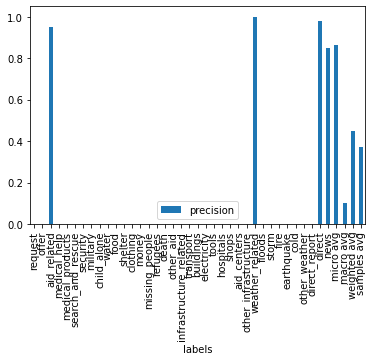

In [143]:
df_evaluation[["labels", "precision"]].plot(x="labels", y = "precision", kind="bar", rot=90);

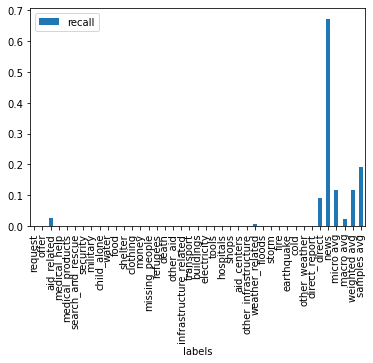

In [144]:
df_evaluation[["labels", "recall"]].plot(x="labels", y = "recall", kind="bar", rot=90);

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline

pred = best_clf.predict(X_test)
sns.heatmap(confusion_matrix(y_test, pred), annot = True, fmt = '')

### 6.Default model
Use grid search to find better parameters. 

In [128]:
def build_model():
    '''Build a Machine Learning pipeline using TfidfTransformer, RandomForestClassifier and GridSearchCV
    Input: 
        None
    Output:
        cv(sklearn.model_selection._search.GridSearchCV): Results of GridSearchCV
    '''
    text_clf  = Pipeline([
                        ('vect', CountVectorizer(tokenizer=tokenize)),
                        ('tfidf', TfidfTransformer()),
                        ('clf', MultiOutputClassifier(estimator=RandomForestClassifier())) 
                        ])
    
    return text_clf

In [130]:
model = build_model()
model.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at...
                                                                        ccp_alpha=0.0,
                                                                        class_weight=None,
                                                                        criterion='gini',
                                                                   

In [133]:
df_evaluation_no_grid = evaluate_model(model, X_test, y_test, labels)
df_evaluation_no_grid

,labels,precision,recall,f1-score,support
0,request,0.838772,0.488268,0.617232,895.0
1,offer,0.000000,0.000000,0.000000,26.0
2,aid_related,0.749355,0.681840,0.714005,2131.0
3,medical_help,0.629032,0.092417,0.161157,422.0
4,medical_products,0.833333,0.092593,0.166667,270.0
5,search_and_rescue,0.687500,0.086614,0.153846,127.0
6,security,0.250000,0.011364,0.021739,88.0
7,military,0.611111,0.070968,0.127168,155.0
8,child_alone,0.000000,0.000000,0.000000,0.0
9,water,0.875000,0.351032,0.501053,339.0


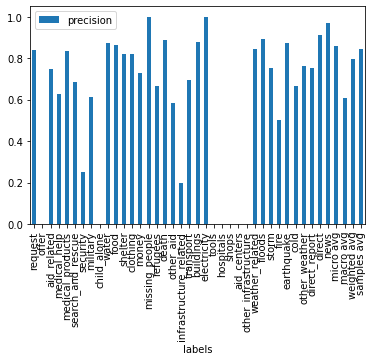

In [134]:
df_evaluation_no_grid[["labels", "precision"]].plot(x="labels", y = "precision", kind="bar", rot=90);

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### 9. Export your model as a pickle file

In [147]:
def save_model(model, filepath):
    '''Saves the model to defined filepath
    Input 
        model(sklearn.model_selection._search.GridSearchCV): The model to be saved.
        model_filepath(str): Filepath  where the model will be saved.
    Output
        This function will save the model as a pickle file on the defined filepath.
    '''    
    temporary_pickle = open(filepath, 'wb')
    pickle.dump(model, temporary_pickle)
    temporary_pickle.close()
    print("Model has been succesfully saved!")

save_model(model, "models/model.pkl")

Model has been succesfully saved!


### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.

In [ ]:
# Feature importance

In [ ]:
#  Import a supervised learning model that has 'feature_importances_'
#from sklearn.tree import DecisionTreeClassifier

# Train the supervised model on the training set using .fit(X_train, y_train)
#model = DecisionTreeClassifier()
#model.fit(X_train, y_train)

#  Extract the feature importances using .feature_importances_ 
#importances = model.feature_importances_

# Plot
#vs.feature_plot(importances, X_train, y_train)